<div class="markdown-google-sans">
  <h1>Chào mừng bạn đến với Colab!</h1>
</div>

<div class="markdown-google-sans">
  <h2>&#40;Mới&#41; Dùng thử Gemini API</h2>
  <ul>
  <li><a href="https://makersuite.google.com/app/apikey">Generate a Gemini API key</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Talk_to_Gemini_with_Google%27s_Speech_to_Text_API.ipynb?utm_medium=link&utm_campaign=gemini">Talk to Gemini with the Speech-to-Text API</a></li>
  <li><a href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API: Quickstart with Python</a></li>
  <li><a href="https://colab.research.google.com/notebooks/snippets/gemini.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API code sample</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Learning_with_Gemini_and_ChatGPT.ipynb?utm_medium=link&utm_campaign=gemini">Compare Gemini with ChatGPT</a></li>  
  <li><a href="https://colab.google/notebooks/?utm_medium=link&utm_campaign=gemini">More notebooks</a></li>
  </ul>
</div>


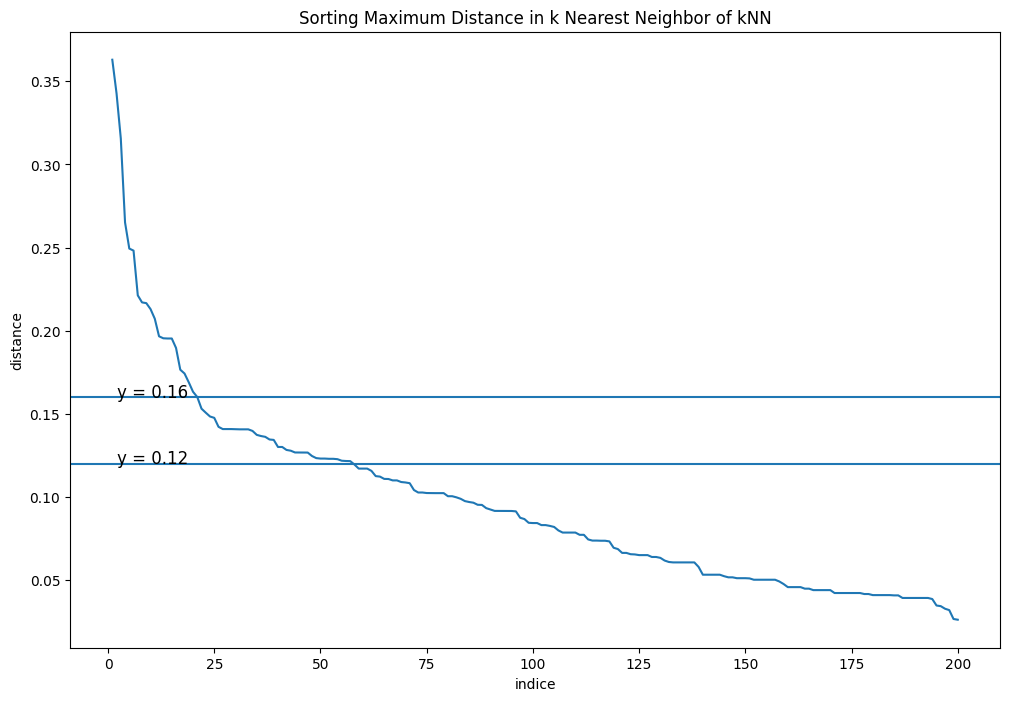

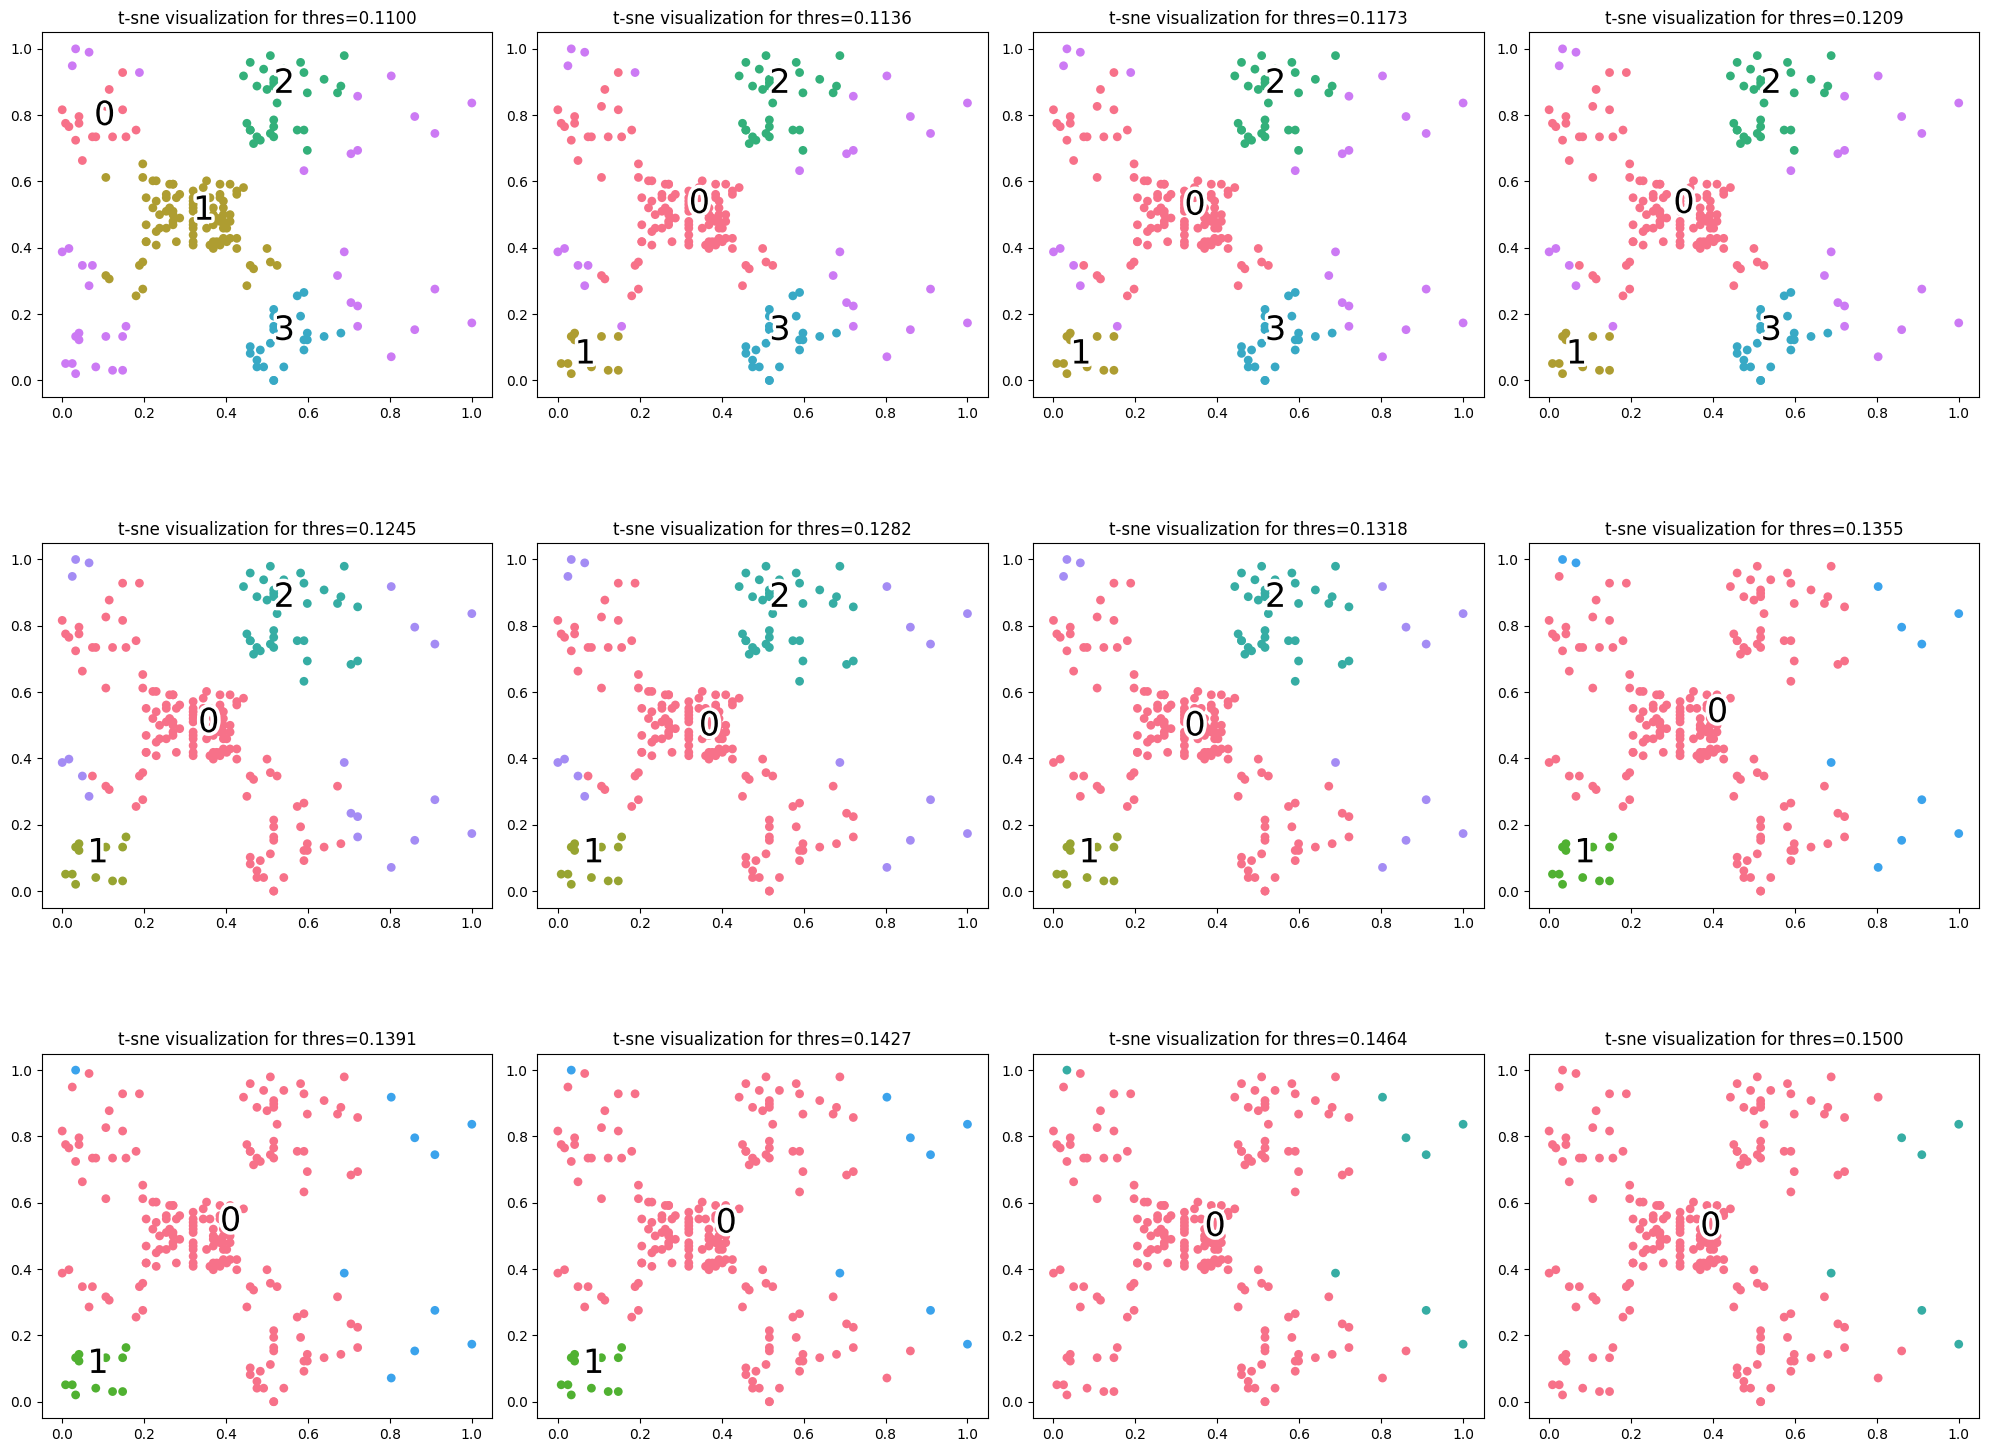

In [30]:
# from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from matplotlib.gridspec import GridSpec

import scipy.cluster.hierarchy as shc
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import array as arr
import numpy as np
import copy

data = pd.read_csv(
    "https://raw.githubusercontent.com/phamdinhkhanh/datasets/cf391fa1a7babe490fdd10c088f0ca1b6d377f59/shopping-data.csv",
    header=0,
    index_col=0,
)


# Lấy ra thu nhập va điểm shopping
X = data.iloc[:, 2:4].values

std = MinMaxScaler()
X_std = std.fit_transform(X)



# Xây dựng mô hình k-Means với k=10
neighbors = 10
nbrs = NearestNeighbors(n_neighbors=neighbors).fit(X_std)

# Ma trận khoảng cách distances: (N, k)
distances, indices = nbrs.kneighbors(X_std)

# Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần.
distance_desc = sorted(distances[:, neighbors - 1], reverse=True)

# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(list(range(1, len(distance_desc) + 1)), distance_desc)
plt.axhline(y=0.12)
plt.text(2, 0.12, "y = 0.12", fontsize=12)
plt.axhline(y=0.16)
plt.text(2, 0.16, "y = 0.16", fontsize=12)
plt.ylabel("distance")
plt.xlabel("indice")
plt.title("Sorting Maximum Distance in k Nearest Neighbor of kNN")


warnings.simplefilter("ignore", category=RuntimeWarning)

#DBSCAN not using library DBSCAN in scikit.learn
class DBSCAN:
    def __init__(self, eps, min_samples):
      self.eps = eps
      self.min_samples = min_samples

    def distance_Euclidean(self, point1, point2):
      return np.linalg.norm(point1 - point2)

    def get_neighbours(self, point):
      neighbours = []
      for i in range(len(self.data)):
        if self.distance_Euclidean(self.data[i], point) <= self.eps:
          neighbours.append(i)
      return neighbours

    def assign_label(self, current_cluster, core_point, neighbours):
      self.visited[core_point] = 1
      self.labels[core_point] = current_cluster
      for neighbour_id in neighbours:
        if neighbour_id == core_point or self.visited[neighbour_id] == 1:
          continue
        if neighbour_id in self.core_points:
          self.assign_label(current_cluster, neighbour_id, self.neighbours[neighbour_id])
        elif self.labels[neighbour_id] == -1:
          self.labels[neighbour_id] = current_cluster
          self.visited[neighbour_id] = 1

    def fit(self, data):
        self.data = np.array(copy.deepcopy(data))
        self.neighbours = [self.get_neighbours(point) for point in self.data]
        self.core_points = [point_id for point_id, neighbours in enumerate(self.neighbours) if len(neighbours) >= self.min_samples]
        self.current_cluster = 0
        self.labels = [-1] * (len(self.data))
        self.visited = [0] * len(self.data)

        if len(self.core_points) == 0:
          return np.array(self.labels)

        for core_point in self.core_points:
          if self.visited[core_point] == 1:
            continue
          self.assign_label(self.current_cluster, core_point, self.neighbours[core_point])
          self.current_cluster += 1

        return np.array(self.labels)


def _plot_kmean_scatter(X, labels, gs, thres):
    """
    X: dữ liệu đầu vào
    labels: nhãn dự báo
    """
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))

    palette = np.array(sns.color_palette("husl", num_classes))



    # vẽ biểu đồ scatter
    ax = plt.subplot(gs)
    sc = ax.scatter(X[:, 0], X[:, 1], lw=0, s=40, c=palette[labels.astype(np.int_)])

    # thêm nhãn cho mỗi cluster
    txts = []

    for i in range(num_classes):

        # Vẽ text tên cụm tại trung vị của mỗi cụm
        indices = labels == i
        if indices.any():  # Check if there are any points in the cluster
            cluster_center = np.median(X[indices, :], axis=0)
            if cluster_center.shape[0] >= 2:  # Check if the cluster center has at least two dimensions
                xtext, ytext = cluster_center[0], cluster_center[1]
                txt = ax.text(xtext, ytext, str(i), fontsize=24)
                txt.set_path_effects(
                    [PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]
                )
                txts.append(txt)

    plt.title("t-sne visualization for thres={:.4f}".format(thres))


gs = GridSpec(3, 4)
plt.figure(figsize=(25, 18))
plt.subplots_adjust(wspace=0.1, hspace=0.4)

for i, thres in enumerate(np.linspace(0.11, 0.15, 12)):

    A = np.zeros((X_std.shape[0],), dtype=int)
    cluster_gr = 1

    dbscan = DBSCAN(thres, 11)
    labels = dbscan.fit(X_std)
    # print(labels)

    _plot_kmean_scatter(X_std, labels, gs[i], thres)


Nếu bạn đã quen dùng Colab, hãy xem video này để tìm hiểu về các bảng tương tác, chế độ xem lịch sử thực thi mã và bảng lệnh.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  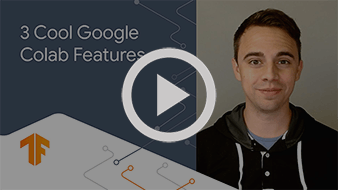
  </a>
</center>

<div class="markdown-google-sans">
  <h2>Colab là gì?</h2>
</div>

Colab &#40;hay còn gọi là "Colaboratory"&#41; cho phép bạn viết và thực thi Python trong trình duyệt với các lợi ích sau:
- Không yêu cầu cấu hình
- Quyền truy cập miễn phí vào GPU
- Chia sẻ dễ dàng

Cho dù bạn là <strong>sinh viên</strong>, <strong>nhà khoa học dữ liệu</strong> hay <strong>nhà nghiên cứu AI &#40;trí tuệ nhân tạo&#41;</strong>, Colab đều giúp bạn hoàn thành công việc dễ dàng hơn. Hãy xem phần <a href="https://www.youtube.com/watch?v=inN8seMm7UI">Hướng dẫn về Colab</a> để tìm hiểu thêm hoặc bắt đầu ngay ở bên dưới!

<div class="markdown-google-sans">

## <strong>Bắt đầu</strong>
</div>

Tài liệu bạn đang đọc không phải là trang web tĩnh, mà là một môi trường tương tác được gọi là <strong>sổ tay trên Colab</strong>. Trên đó, bạn có thể viết và thực thi mã.

Ví dụ: sau đây là một <strong>ô chứa mã</strong> có tập lệnh Python ngắn tính toán một giá trị, lưu trữ giá trị đó trong một biến và in kết quả:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

Để thực thi mã trong ô trên, hãy nhấp để chọn mã đó rồi nhấn nút phát ở bên trái mã hoặc sử dụng tổ hợp phím tắt "Command/Ctrl+Enter". Để chỉnh sửa mã này, bạn chỉ cần nhấp vào ô đó và bắt đầu chỉnh sửa.

Các biến mà bạn xác định trong một ô có thể dùng trong các ô khác sau này:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Sổ tay trên Colab cho phép bạn kết hợp <strong>mã có thể thực thi</strong> và <strong>văn bản đa dạng thức</strong> trong một tài liệu duy nhất, cùng với <strong>hình ảnh</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> và nhiều nội dung khác. Khi bạn tạo sổ tay của riêng mình trên Colab, các sổ tay đó sẽ được lưu trữ trong tài khoản Google Drive của bạn. Bạn có thể dễ dàng chia sẻ sổ tay của mình trên Colab với đồng nghiệp hoặc bạn bè, cho phép họ nhận xét hoặc thậm chí là chỉnh sửa các sổ tay đó. Để tìm hiểu thêm, hãy xem phần <a href="/notebooks/basic_features_overview.ipynb">Tổng quan về Colab</a>. Để tạo một sổ tay mới trên Colab, bạn có thể sử dụng trình đơn Tệp ở trên hoặc sử dụng đường liên kết sau: <a href="http://colab.research.google.com#create=true">tạo một sổ tay mới trên Colab</a>.

Sổ tay trên Colab là các sổ tay Jupyter được Colab lưu trữ. Để tìm hiểu thêm về dự án Jupyter, hãy xem <a href="https://www.jupyter.org">jupyter.org</a>.

<div class="markdown-google-sans">

## Khoa học dữ liệu
</div>

Với Colab, bạn có thể khai thác toàn bộ sức mạnh của các thư viện Python phổ biến để phân tích và trực quan hóa dữ liệu. Ô chứa mã ở bên dưới sử dụng <strong>numpy</strong> để tạo một số dữ liệu ngẫu nhiên và sử dụng <strong>matplotlib</strong> để trực quan hóa dữ liệu đó. Để chỉnh sửa mã này, bạn chỉ cần nhấp vào ô đó và bắt đầu chỉnh sửa.

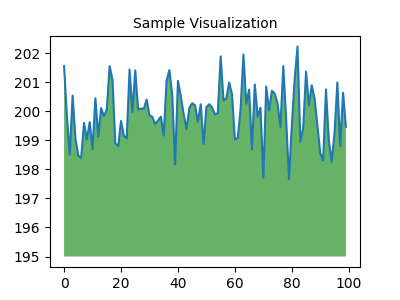

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Bạn có thể nhập dữ liệu của riêng mình vào các sổ tay trên Colab từ tài khoản Google Drive, bao gồm từ bảng tính, cũng như từ GitHub và nhiều nguồn khác. Để tìm hiểu thêm về cách nhập dữ liệu và cách áp dụng Colab cho ngành khoa học dữ liệu, hãy xem các đường liên kết trong phần <a href="#working-with-data">Làm việc với dữ liệu</a>.

<div class="markdown-google-sans">

## Máy học
</div>

Với Colab, chỉ cần sử dụng <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">một vài dòng mã</a> là bạn có thể nhập tập dữ liệu hình ảnh, huấn luyện một trình phân loại hình ảnh dựa trên tập dữ liệu đó và đánh giá mô hình này. Sổ tay trên Colab thực thi mã trên các máy chủ đám mây của Google. Nhờ đó, bạn có thể tận dụng sức mạnh của phần cứng Google, bao gồm cả <a href="#using-accelerated-hardware">GPU và TPU</a>, cho dù máy tính của bạn sử dụng sức mạnh phần cứng nào. Bạn chỉ cần một trình duyệt.

Colab được sử dụng rộng rãi trong cộng đồng máy học với các ứng dụng như:
- Bắt đầu sử dụng TensorFlow
- Phát triển và huấn luyện mạng nơron
- Thử nghiệm có sử dụng TPU
- Phổ biến nghiên cứu về AI &#40;trí tuệ nhân tạo&#41;
- Tạo hướng dẫn

Để xem các sổ tay mẫu trên Colab minh họa các ứng dụng dùng mô hình máy học, hãy xem <a href="#machine-learning-examples">các ví dụ về máy học</a> ở bên dưới.

<div class="markdown-google-sans">

## Tài nguyên khác

### Làm việc với Sổ tay trong Colab

</div>

- [Tổng quan về Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Hướng dẫn sử dụng Markdown](/notebooks/markdown_guide.ipynb)
- [Nhập thư viện và cài đặt phần phụ thuộc](/notebooks/snippets/importing_libraries.ipynb)
- [Lưu và tải sổ tay trong GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Biểu mẫu tương tác](/notebooks/forms.ipynb)
- [Tiện ích tương tác](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Làm việc với dữ liệu
</div>

- [Tải dữ liệu: Drive, Trang tính và Google Cloud Storage](/notebooks/io.ipynb)
- [Biểu đồ: trực quan hóa dữ liệu](/notebooks/charts.ipynb)
- [Bắt đầu sử dụng BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Khóa học máy học ứng dụng

<div>

Khóa học trực tuyến của Google về Máy học có cung cấp một số sổ tay. Hãy xem <a href="https://developers.google.com/machine-learning/crash-course/">trang web của toàn bộ khóa học</a> để biết thêm thông tin.
- [Giới thiệu về Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Hồi quy tuyến tính bằng tf.keras sử dụng dữ liệu tổng hợp](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Sử dụng phần cứng tăng tốc
</div>

- [TensorFlow có GPU](/notebooks/gpu.ipynb)
- [TensorFlow có TPU](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Ví dụ điển hình

</div>

- <a href="https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb">Ứng dụng hoán đổi giọng nói NeMo</a>: Dùng Bộ công cụ AI &#40;trí tuệ nhân tạo&#41; NeMo có khả năng trò chuyện của Nvidia để hoán đổi giọng nói trong một đoạn âm thanh với giọng nói do máy tính tạo.

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Huấn luyện lại trình phân loại hình ảnh</a>: Tạo một mô hình Keras cùng với trình phân loại hình ảnh đã được huấn luyện trước để phân biệt các loại hoa.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Phân loại văn bản</a>: Phân loại các bài đánh giá phim trên IMDB là <em>tích cực</em> hoặc <em>tiêu cực</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Sao chép phong cách</a>: Sử dụng mô hình học sâu để sao chép phong cách giữa các hình ảnh.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Hỏi và đáp về Bộ mã hóa câu tổng quát đa ngôn ngữ</a>: Sử dụng một mô hình máy học để giải đáp các câu hỏi từ tập dữ liệu SQuAD.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Nội suy video</a>: Dự đoán những điều đã xảy ra trong một video từ khung hình đầu tiên đến khung hình cuối cùng.
